## Small Deep Neural Networks (CNN) for Spanish Political Affinity using People Photos

**Note: all folders are empty in order to respect the privacy of the politicians! There is no public dataset, final model or predictions. I used izquierda (left) for PSOE and derecha (right) for PP.**

Maybe you have the same question: why sometime I can say the political affinity of a person from watching the TV. If my brain can detect complex patterns in the images, I am trying to simulate a simpler artificial network version: a convolutional neural network (deep learning). Let's see if a simple CNN is able to detect the political affinity using face pictures. I will use a very small dataset of images: 50-50 for left–right Spanish politicians. For the small CNNs, keras data augmentation will be used during the training.

After splitting the dataset into train and validation subfolders, I shall try different neural networks from small CNNs to VGG nets using Transfer Learning/Fine Tuning.

Let's import some packages for the next calculations:

In [1]:
import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import roc_auc_score
from numpy.random import seed
from tensorflow import set_random_seed

import time, os
from __future__ import with_statement

%matplotlib inline

c:\program files\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


This is a function that will help you to visualize the training and validation accuracy during the training inside the browser (source: [live_loss_plot_keras.ipynb](https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e)).

**Note**: if you want to run the training script not inside the notebook, you need to remove this function call from your traning! If not, after each epoch you will need to manually close the new plot!

In [2]:
class PlotLosses(keras.callbacks.Callback):
    # Show the live training and validation loss during the training
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.acc, label="ACC_Train")
        plt.plot(self.x, self.val_acc, label="ACC_Val")
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=2, mode="expand", borderaxespad=0.)
        plt.grid()
        # plt.ylim(0.0, 1.0) # limited Y values to 1.0!
        plt.show()

plot_losses = PlotLosses() # initialize the class

Define several constants:
* dimensions for our images to be used in the models
* folders for train and validation subsets
* number of train and validation samples

In [3]:
# Dimensions of our images
img_width, img_height = 150, 150

# Train & validation folders
train_data_dir      = 'data_politics/train'
validation_data_dir = 'data_politics/validation'

# Folder to save the models
modelFolder = 'saved_models'

# Train parameters
nb_train_samples      = 80
nb_validation_samples = 20

Change the order of the dimensions and channel depending on the input image: (channels, width, height) or (width, height, channels). We are using 3 channels for this study (RGB).

In [4]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Small CNNs: 1 Conv + 1 FC

We start our calculations using a CNN with a convolution block and a fully-connected layer. The next section is a function for this type of CNN with 5 parameters: number of filters, dimension of the convolution, epochs, batch size and size of the inputs. You could personalize this function with other parameters such as dropout rate, activation function, etc.

`CNN_1Conv_1FC` will have the following characteristics explained into the code:
* Uses 2 types of seed for the maximum reproductibility: one for numpy, other for tensorflow; remember that each GPU could still involve some random data.
* Conv layer is using `relu` activation function and `MaxPooling2D`.
* FC layer is using the same `relu` activation and a `dropout = 0.7`.
* The output layer is using `sigmoid` activation for PSOE / PP classification.
* The loss functions is using the `binary cross entropy` optimization with `adam` algorithm with `accuracy` metrics.
* `ImageDataGenerator` form keras is using to create augmented images from the original using different transformations such as flipping, rotation, zoom, etc. You could add other transformation!
* The fitting of the model is using a custom callbacks class to plot the loss and accuracy during the training (`plot_losses`).
* The weights and the full model are saved as files (**No results are inclided in the currrent project due privacy!**).
* Show the final trainign and test lose.
* Show the live plot during the training similar with Tensorboard.

In [7]:
def CNN_1Conv_1FC(convs, dims, epochs, batch_size, input_shape):
    # CNN with 1 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # input_shape = shape of the inputs
    
    # for reproductibility
    #seed(74)            # numpy seed
    #set_random_seed(74) # tensorflow seed
    
    # Start the computational graph for our CNN
    model = Sequential()
    
    # CNN filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        rotation_range=40,
        fill_mode='nearest')

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    print('Validation/Test loss    :', score[0])
    print('Validation/Test accuracy:', score[1])
    
    return model # return the model!

Search for a CNN with 32 filter of 3 x 3 pixels:

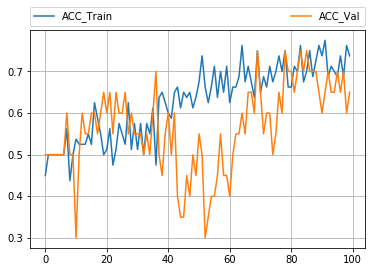

Validation/Test loss    : 0.613640308380127
Validation/Test accuracy: 0.65
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_45 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 175232)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                5607456   
_________________________________________________________________
activation_46 (Activation)   (None, 32)                0         
_________________________________________________________________
d

In [21]:
print('--> Training Conv-FC ver 1 ...')
model = CNN_1Conv_1FC(convs=32, dims=3, epochs=100, batch_size=4, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model1_1_Conv-FC_weigths.h5'))
print('Done!')

**Conclusion**: with a `Conv + FC topology with 32 filters of 3 x 3 pixels`, we are able to obtain a classifier with over `70% test accuracy` for the polyps vs non-polyps prediction! Remember, we are not using any transfer learning, we are training a simple CNN. We are training `5,608,385 parameters`!

Let's check a second CNN but with filter of `5 x 5` pixels:

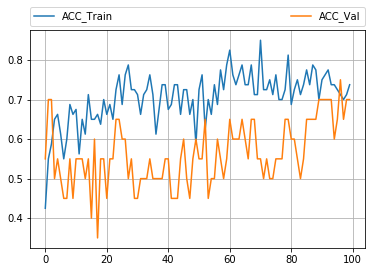

Validation/Test loss    : 0.7399532794952393
Validation/Test accuracy: 0.7
---> Save model ...
Done!


In [22]:
print('--> Training Conv-FC ver 2 ...')
model = CNN_1Conv_1FC(convs=32, dims=5, epochs=100, batch_size=4, input_shape= input_shape)
# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model1_2_Conv-FC_weigths.h5'))
print('Done!')

**Conclusion**: in the case of the `Conv + FC topology, 32 filters 5 x 5` the results are similar (`5,459,393 parameters`). This means bigger filters are not able to find the best patterns for this classification.

Maybe it could improve with the increasing of the number of filters 3 x 3. Let's test with 64 filters (double than the previous ones):

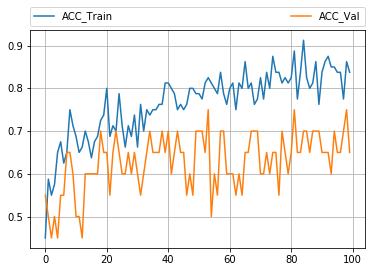

Validation/Test loss    : 0.7995704054832459
Validation/Test accuracy: 0.65
---> Save model ...
Done!


In [34]:
print('--> Training Conv-FC ver 3 ...')
model = CNN_1Conv_1FC(convs=64, dims=3, epochs=100, batch_size=4, input_shape= input_shape)
# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model1_3_Conv-FC_weigths.h5'))
print('Done!')

Let's try `128` filters with `3 x 3` pixels (double than previous calculation and 4 times greater than the first model):

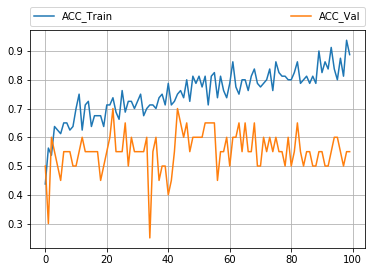

Validation/Test loss    : 0.9918397903442383
Validation/Test accuracy: 0.55
---> Save model ...
Done!


In [24]:
print('--> Training Conv-FC ver 4 ...')
model = CNN_1Conv_1FC(convs=128, dims=3, epochs=100, batch_size=4, input_shape= input_shape)
# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model1_4_Conv-FC_weigths.h5'))
print('Done!')

**Conclusions**: With only one Conv block, it is possible to obtain **over 70% of accuracy** for prediction of political accuracy.

In the next step, we add extra convolutional layers to the CNN.

### Small CNNs: 2 Conv + 1 FC

We continue our study by adding an extra Conv layer. The main idea is to try to have an extra layer that could find more general patterns from the basic ones in the first Conv layer. Thus, we define a second CNN topology with **Conv-Conv-FC** (`CNN_2Conv_1FC`). I will use `adam` optimizer for faster calculations.

In [25]:
def CNN_2Conv_1FC(convs, dims, epochs, batch_size, input_shape):
    # CNN with 2 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # input_shape = shape of the inputs
    
    # for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed
    
    # Start the computational graph for our CNN
    model = Sequential()
    
    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 2 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer= 'adam', # 'rmsprop',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        rotation_range=40,
        fill_mode='nearest')

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    print('Validation/Test loss    :', score[0])
    print('Validation/Test accuracy:', score[1])
    
    return model # return the model!

Let's see the classifier for this topology using `32 filters - 64 filters - 64 FC`. All filters are 3 x 3 pixels.

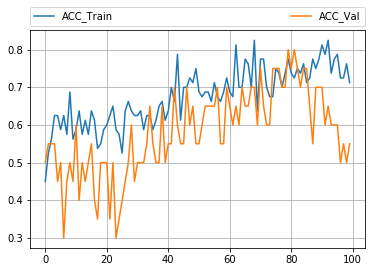

Validation/Test loss    : 0.8830771267414093
Validation/Test accuracy: 0.55
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_57 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_58 (Activation)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________


In [26]:
print('--> Training Conv-Conv-FC ver 1 ...')
model = CNN_2Conv_1FC(convs=32, dims=3, epochs=100, batch_size=4, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model2_1_Conv-Conv-FC_weigths.h5'))
print('Done!')

**Conclusions**: By adding the second Conv layer we can see accuracy improvment over 75% using `5,327,937 parameters`.

In the next step, we shall try the same topology Conv 64 - Conv 128  - FC (with a double number of filters):

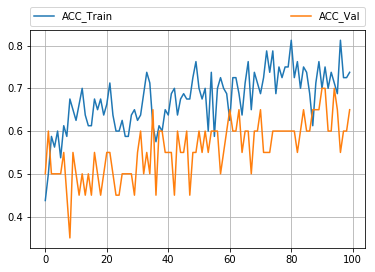

Validation/Test loss    : 0.6372703790664673
Validation/Test accuracy: 0.65
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
activation_61 (Activation)   (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 72, 72, 128)       73856     
_________________________________________________________________
activation_62 (Activation)   (None, 72, 72, 128)       0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________


In [27]:
print('--> Training Conv-Conv-FC ver 2 ...')
model = CNN_2Conv_1FC(convs=64, dims=3, epochs=100, batch_size=4, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model2_2_Conv-Conv-FC_weigths.h5'))
print('Done!')

**Conclusions**: By doubling the number of filters for `Conv-Conv-FC` with `21,309,569 parameters` no better results are obtained.

### Small CNNs: 3 Conv - 1FC

In the next step, we shall add the 3rd Conv layer to obtain a similar topology with the LeCun net: `Conv-Conv-Conv-FC`:

In [28]:
def CNN_3Conv_1FC(convs, dims, epochs, batch_size, input_shape):
    # CNN with 3 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # input_shape = shape of the inputs
    
    # for reproductibility
    seed(1)            # numpy seed
    set_random_seed(2) # tensorflow seed
    
    # Start the computational graph for our CNN
    model = Sequential()
    
    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 2 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 3 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        rotation_range=40,
        fill_mode='nearest')

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    print('Validation/Test loss    :', score[0])
    print('Validation/Test accuracy:', score[1])
    
    return model # return the model!

Let's try `Conv-Conv-Conv-FC` with 32, 32 and 64 filters (3 x 3):

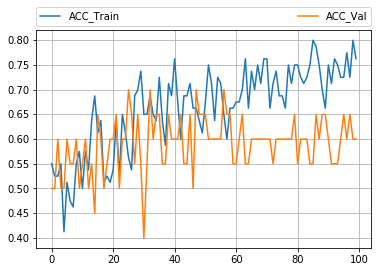

Validation/Test loss    : 0.790895962715149
Validation/Test accuracy: 0.6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_65 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_66 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
co

In [29]:
print('--> Training Conv-Conv-Conv-FC ver 1 ...')
model = CNN_3Conv_1FC(convs=32, dims=3, epochs=100, batch_size=4, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model3_1_Conv-Conv-Conv-FC_weigths.h5'))
print('Done!')

Let's try `Conv-Conv-Conv-FC` with double number of filters: 64, 64 and 128 filters (3 x 3):

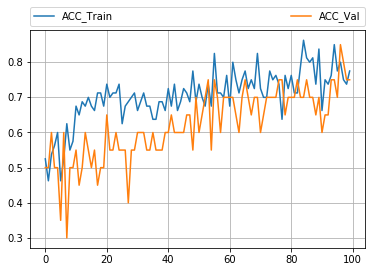

Validation/Test loss    : 0.5606055438518525
Validation/Test accuracy: 0.75
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
activation_70 (Activation)   (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
activation_71 (Activation)   (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________


In [30]:
print('--> Training Conv-Conv-Conv-FC ver 2 ...')
model = CNN_3Conv_1FC(convs=64, dims=3, epochs=100, batch_size=4, input_shape= input_shape)

print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model3_2_Conv-Conv-Conv-FC_weigths.h5'))
print('Done!')

Good! It is possible to obtain at least 75% accuracy in only 100 iterations! So, let's see what we can have in 100 iterations:

**Conclusions**: Using `Conv-Conv-Conv-FC` topologies are improving the accuracy over `75% accuracy` (4,847,809 parameters) in 100 iterations! These results confirms the DL theory about the abstract patterns in lower layers to the more general ones in the next layers.

## Hyperparameter optimization for 3 Conv - FC

In the next section, I shall use the topology Conv-Conv-Conv-FC (64, 64, 128 filters) and try to find the best hyperparameters.

In [5]:
def CNN_3Conv_1FC_optim(convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, input_shape):
    # CNN with 3 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # drop_rate = dropout of neurons
    # activFunction = 'relu', 'tanh', etc.
    # input_shape = shape of the inputs
    
    # for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed
    
    # Start the computational graph for our CNN
    model = Sequential()
    
    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation(activFunction))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 2 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation(activFunction))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 3 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation(activFunction))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation(activFunction))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        rotation_range=40,
        fill_mode='nearest')

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        verbose=0,
        workers=7) # using multi-cpu!

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    return (score[0],score[1]) # test loss and accuracy

**Search**: Let's see what we can obtain if we search for the most accurate classifier with different `batch size` and `drop rate` values. I will use `workers=7` in order to use parallel CPU cores for fit and evaluate functions. *Please adapt this value to your device CPU cores!*

**Notes**:
* Topology: Conv-Conv-Conv-FC (64-64-128 filters).
* Filter dimension `3 x 3`, 50 epochs.
* Optimizers are using their default parameters.
* `accuracy` is used for training and testing.
* `binary crossentropy` is the loss function with the last activation function as `sigmoid` (to obtain polyps or non-polyps class).
* `MaxPooling2D` is 2 x 2.
* I will use the `for` loops without other SearchGrid functions.

In [33]:
# Search for the best hyperparameters:  batch size and drop rate
print('--> Search for the best hyperparameters: batch size and drop rate ...')

# Fixed params from the best model in Search 1
convs = 64
dims = 3
epochs = 100
activFunction = 'relu'
optimizer = 'Adam'
print('Fixed params - Filters, Filter size, Epochs, Activations, Optimizer:', convs, dims, epochs, activFunction, optimizer)

# Grid search for parameters
batch_sizeGrid = [2, 4, 5, 10]
drop_rateGrid  = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9]
print('Searching params - Batch size, Drop rate', batch_sizeGrid, drop_rateGrid)

# Start total timer
start_time = time.time()

# get all the results as list
results = []
for batch_size in batch_sizeGrid:
    for drop_rate in drop_rateGrid:
        # timer for each iteration
        istart_time = time.time()
        # get Loss and Accuracy for CNN Conv-Conv-Conv-FC with specific parameters
        iLoss, iAccuracy = CNN_3Conv_1FC_optim(convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, input_shape)
        # append the results to a list
        results.append([convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, iLoss, iAccuracy])
        # print for each iteration the results and the iteration time
        print(convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, iLoss, iAccuracy)
        print("--> Iter time: %0.1f mins ---" % ((time.time() - istart_time) / 60))

# Print total time for the parameter search 
print("Done! Total time: %0.1f mins ---" % ((time.time() - start_time)/60))

--> Search for the best hyperparameters: batch size and drop rate ...
Fixed params - Filters, Filter size, Epochs, Activations, Optimizer: 64 3 100 relu Adam
Searching params - Batch size, Drop rate [2, 4, 5, 10] [0.1, 0.3, 0.5, 0.7, 0.8, 0.9]
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
64 3 100 2 0.1 relu Adam 8.059047718974615 0.5
--> Iter time: 1.0 mins ---
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
64 3 100 2 0.3 relu Adam 0.8154685168978176 0.75
--> Iter time: 1.0 mins ---
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
64 3 100 2 0.5 relu Adam 0.8460949718952179 0.65
--> Iter time: 1.0 mins ---
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
64 3 100 2 0.7 relu Adam 1.0186505019664764 0.4
--> Iter time: 1.0 mins ---
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
64 3 100 2 0.8 relu Adam 0.6850826472043992 0.5
-->

Let's save these results on the disk as `ParamSearch.csv` in `results` subfolder:

In [7]:
def WriteListOfList(sFile, header):
    # Write search results to disk
    # sFile = path + filename to write the list
    # header = custom header for the list data

    with open(sFile, 'w') as f:
        f.write(header)
        for _list in results:
            sout = ''
            for _string in _list:
                sout = sout + str(_string) + ','
            f.write(sout[:-1] + '\n')

In [36]:
sFile = './results/ParamSearch.csv'
header= 'filterNo, filterSize, epochs, batch_size, drop_rate, activFunction, optimizer, Loss, Accuracy\n'
WriteListOfList(sFile, header)

In the results for the second search parameters we can see that same set of hyperparameters gives the best accuracy results. The accuracy difference are generated by several random initializations such as weigths in layers, etc.

filterNo, filterSize, epochs, batch_size, drop_rate, activFunction, optimizer, Loss, Accuracy
64,3,100,2,0.3,relu,Adam,0.815468517,0.750
64,3,100,10,0.7,relu,Adam,0.805603415,0.700
64,3,100,10,0.8,relu,Adam,0.648522973,0.700
64,3,100,5,0.5,relu,Adam,0.845411018,0.700
64,3,100,4,0.5,relu,Adam,0.721278152,0.700
64,3,100,10,0.1,relu,Adam,0.786382914,0.700
64,3,100,5,0.7,relu,Adam,1.047737777,0.650
64,3,100,5,0.1,relu,Adam,0.866875269,0.650
64,3,100,5,0.3,relu,Adam,0.646905981,0.650
64,3,100,10,0.5,relu,Adam,1.212804556,0.650
64,3,100,2,0.5,relu,Adam,0.846094972,0.650
64,3,100,4,0.1,relu,Adam,1.006403366,0.650
64,3,100,4,0.3,relu,Adam,1.159122646,0.650
64,3,100,4,0.7,relu,Adam,0.83178063,0.600
64,3,100,10,0.3,relu,Adam,1.895883799,0.550
64,3,100,5,0.8,relu,Adam,0.741803408,0.500
64,3,100,5,0.9,relu,Adam,0.693147212,0.500
64,3,100,10,0.9,relu,Adam,0.768612564,0.500
64,3,100,2,0.1,relu,Adam,8.059047719,0.500
64,3,100,2,0.8,relu,Adam,0.685082647,0.500
64,3,100,2,0.9,relu,Adam,0.693152648,0.500
64,3,100,4,0.8,relu,Adam,0.8171085,0.500
64,3,100,4,0.9,relu,Adam,0.872917426,0.450
64,3,100,2,0.7,relu,Adam,1.018650502,0.400

Let's train to keep batch size and drop rate for the best result and search for different values of the convs (number of filters) and dims (dimension of the filters/kernels):

In [6]:
# Search for the best hyperparameters:  conv and dims
print('--> Search for the best hyperparameters: batch size and drop rate ...')

# Fixed params from the best model in Search 1
epochs = 50
activFunction = 'relu'
optimizer = 'Adam'
batch_size = 2
drop_rate = 0.3

print('Fixed params - Batch size, Drop Rate, Epochs, Activations, Optimizer:', batch_size, drop_rate, epochs, activFunction, optimizer)

# Grid search for parameters
convs_sizeGrid = [32, 64, 128]
dims_rateGrid  = [3, 5, 7, 9]
print('Searching params - No filters, Dim filters', convs_sizeGrid, dims_rateGrid)

# Start total timer
start_time = time.time()

# get all the results as list
results = []
for convs in convs_sizeGrid:
    for dims in dims_rateGrid:
        # timer for each iteration
        istart_time = time.time()
        # get Loss and Accuracy for CNN Conv-Conv-Conv-FC with specific parameters
        iLoss, iAccuracy = CNN_3Conv_1FC_optim(convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, input_shape)
        # append the results to a list
        results.append([convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, iLoss, iAccuracy])
        # print for each iteration the results and the iteration time
        print(convs, dims, epochs, batch_size, drop_rate, activFunction, optimizer, iLoss, iAccuracy)
        print("--> Iter time: %0.1f mins ---" % ((time.time() - istart_time) / 60))

# Print total time for the parameter search 
print("Done! Total time: %0.1f mins ---" % ((time.time() - start_time)/60))

--> Search for the best hyperparameters: batch size and drop rate ...
Fixed params - Batch size, Drop Rate, Epochs, Activations, Optimizer: 2 0.3 50 relu Adam
Searching params - No filters, Dim filters [32, 64, 128] [3, 5, 7, 9]
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
32 3 50 2 0.3 relu Adam 0.5819033220410347 0.8
--> Iter time: 0.7 mins ---
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
32 5 50 2 0.3 relu Adam 0.730002623796463 0.45
--> Iter time: 0.5 mins ---
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
32 7 50 2 0.3 relu Adam 0.7382449269294739 0.4
--> Iter time: 0.5 mins ---
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
32 9 50 2 0.3 relu Adam 7.971192395687116 0.5
--> Iter time: 0.5 mins ---
Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
64 3 50 2 0.3 relu Adam 0.6192711859941482 0.65
--> Iter time: 0.5 mins 

In [8]:
sFile = './results/ParamSearch2.csv'
header= 'filterNo, filterSize, epochs, batch_size, drop_rate, activFunction, optimizer, Loss, Accuracy\n'
WriteListOfList(sFile, header)

Let's adapt the function to calculate the best model:

In [10]:
def CNN_3Conv_1FCv2(convs, dims, epochs, batch_size, drop_rate, input_shape):
    # CNN with 3 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # drop_rate = drop rate (0, 1.0) <---- added
    # input_shape = shape of the inputs
    
    # for reproductibility
    seed(1)            # numpy seed
    set_random_seed(2) # tensorflow seed
    
    # Start the computational graph for our CNN
    model = Sequential()
    
    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 2 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 3 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation('relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        rotation_range=40,
        fill_mode='nearest')

    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[plot_losses], # using the plotting function for train and validation loss
        verbose=0)

    # Evaluate final test loss and accuracy scores
    score_val = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    score_tr  = model.evaluate_generator(train_generator, nb_train_samples//batch_size, workers=7)
    print('Train loss    :', score_tr[0])
    print('Train accuracy:', score_tr[1])
    print('Validation loss    :', score_val[0])
    print('Validation accuracy:', score_val[1])
    
    return model # return the model!

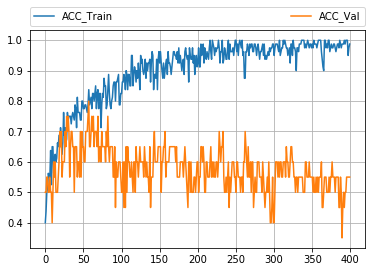

Train loss    : 0.06413151505053864
Train accuracy: 0.9875
Validation loss    : 5.569628882425912
Validation accuracy: 0.55
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_106 (Activation)  (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_107 (Activation)  (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 36, 36, 32)        0         
__________________

In [11]:
print('--> Training best model for Small CNNs: Conv-Conv-Conv-FC ...')
model = CNN_3Conv_1FCv2(convs=32, dims=3, epochs=400, batch_size=2,
                        drop_rate=0.3, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save_weights(os.path.join(modelFolder,'model_best2_Conv-Conv-Conv-FC_weigths.h5'))
model.save(os.path.join(modelFolder,'model_bestx_Conv-Conv-Conv-FC_full.h5'))
print('Done!')

**Conclusion**: The best model for colonoscopy using a small CNN could have an test accuracy of `80%` using a limited number of images but using keras data augmentation. Early stopping should be used to get the best test accuracy model! 

## Final conclusion

If you want a classifier to predict the political affinity of a person, you could get a small dataset with Internet images, and using keras augmented data and a `small CNN` (Conv-Conv-Conv-FC, similar with LeCun), you can obtain an accuracy `over 80% in few minutes`. In the next script, Transfer Learing will be tested with well known already trained models such as VGG or Inception.

Hf with DL! @muntisa

**References**

* [Keras blog with scripts](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

### Acknowledgements

I gratefully acknowledge the support of NVIDIA Corporation with the donation of the Titan Xp GPU used for this research ([https://developer.nvidia.com/academic_gpu_seeding](https://developer.nvidia.com/academic_gpu_seeding)).